In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
import numpy as np
import os
from tqdm import tqdm

# ============== 0) Device ==============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============== 1) Transforms (MRI-safe) ==============
# Keep ImageNet normalization for ImageNet-pretrained CNNs.
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # <- handle grayscale MRI
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ============== 2) Datasets + Loaders ==============
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"  # adjust if needed

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"),   transform=eval_tfms)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=eval_tfms)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)

# Balanced sampling is helpful; but start with shuffle=True first.
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# ============== 3) Model: ResNet-50 (fine-tune) ==============
model = models.resnet50(pretrained=True)

# Replace classifier head
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

# ============== 4) Loss (with optional class weights) ==============
# If your dataset is imbalanced, compute class weights from train targets:
try:
    counts = Counter(train_ds.targets)
    class_weights = torch.tensor([1.0 / counts[i] for i in range(num_classes)], dtype=torch.float32, device=device)
    class_weights = class_weights * (num_classes / class_weights.sum())  # normalize a bit
    print("Class counts:", counts)
    print("Class weights:", class_weights.cpu().numpy())
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
except Exception:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# ============== 5) Optimizers & Schedulers ==============
# Phase A: train head only (warmup)
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# ============== 6) Training helpers ==============
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

def run_epoch(model, loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()

    total_loss, total_correct, total = 0.0, 0, 0
    pbar = tqdm(loader, leave=False)

    for x, y in pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            out = model(x)
            loss = criterion(out, y)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        preds = out.argmax(1)
        total_loss += loss.item() * x.size(0)
        total_correct += (preds == y).sum().item()
        total += x.size(0)

        pbar.set_postfix(loss=f"{total_loss/total:.4f}", acc=f"{total_correct/total:.4f}")

    return total_loss / total, total_correct / total

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# ============== 7) Training schedule ==============
EPOCHS_HEAD   = 3   # head-only warmup
EPOCHS_FINET  = 12  # fine-tune phase (last block + head)
PATIENCE      = 5   # early stopping on val loss
best_val_loss = float("inf")
epochs_no_improve = 0
best_path = "best_resnet50_mri.pt"

print("\n=== Phase A: Train classifier head only ===")
for epoch in range(1, EPOCHS_HEAD+1):
    train_loss, train_acc = run_epoch(model, train_loader, train_mode=True)
    val_loss,   val_acc   = run_epoch(model, val_loader,   train_mode=False)
    scheduler.step(val_loss)

    print(f"[Head] Epoch {epoch}/{EPOCHS_HEAD} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping (head phase).")
            break

# Unfreeze last block (layer4) for fine-tuning with lower LR
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = optim.AdamW([
    {"params": model.fc.parameters(),     "lr": 1e-3},
    {"params": model.layer4.parameters(), "lr": 1e-4},
], weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

print("\n=== Phase B: Fine-tune layer4 + head ===")
epochs_no_improve = 0
for epoch in range(1, EPOCHS_FINET+1):
    train_loss, train_acc = run_epoch(model, train_loader, train_mode=True)
    val_loss,   val_acc   = run_epoch(model, val_loader,   train_mode=False)
    scheduler.step(val_loss)

    print(f"[FT] Epoch {epoch}/{EPOCHS_FINET} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping (fine-tune phase).")
            break

# ============== 8) Load best & Test ==============
model.load_state_dict(torch.load(best_path, map_location=device))
test_acc = evaluate_model(model, test_loader)
print(f"\nBest checkpoint test accuracy: {test_acc:.4f}")


Using device: cuda


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brain-tumor-mri-dataset/train'

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aminehfar","key":"2d4f6af9b6786be61ec95dd320c3d7d2"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content
!unzip -q /content/brain-tumor-mri-dataset.zip -d /content/brain_tumor

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87% 130M/149M [00:00<00:00, 1.35GB/s]
100% 149M/149M [00:00<00:00, 1.35GB/s]


In [5]:
import os
print(os.listdir("/content/brain_tumor"))

['Testing', 'Training']


In [6]:
data_dir = "/content/brain_tumor"
print(os.listdir(data_dir))        # ['Training', 'Testing']
print(os.listdir(f"{data_dir}/Training"))  # ['glioma', 'meningioma', 'notumor', 'pituitary']

['Testing', 'Training']
['glioma', 'meningioma', 'notumor', 'pituitary']


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
import numpy as np
import os
from tqdm import tqdm
import torch.optim.lr_scheduler as lrs
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
# ============== 0) Device ==============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
# ============== 1) Transforms (MRI-safe) ==============
# Keep ImageNet normalization for ImageNet-pretrained CNNs.
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # <- handle grayscale MRI safely
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [10]:
# ---- Config ----
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
NUM_WORKERS = 2

In [11]:
# ============== 2) Datasets + Loaders ==============
DATA_DIR ="/content/brain_tumor"

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "Training"), transform=train_tfms)
#val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"),   transform=eval_tfms)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "Testing"),  transform=eval_tfms)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)



train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
#val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [12]:
# ============== 3) Model: ResNet-50 (fine-tune) ==============
model = models.resnet50(pretrained=True)

# Replace classifier head
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


In [13]:
# ============== 4) Loss (with optional class weights) ==============
# If your dataset is imbalanced, compute class weights from train targets:
try:
    counts = Counter(train_ds.targets)
    class_weights = torch.tensor([1.0 / counts[i] for i in range(num_classes)], dtype=torch.float32, device=device)
    class_weights = class_weights * (num_classes / class_weights.sum())  # normalize a bit
    print("Class counts:", counts)
    print("Class weights:", class_weights.cpu().numpy())
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
except Exception:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)


Class counts: Counter({2: 1595, 3: 1457, 1: 1339, 0: 1321})
Class weights: [1.0748563  1.0604072  0.89021015 0.97452646]


In [14]:
import torch
print(torch.__version__)

2.8.0+cu126


In [15]:
# ============== 5) Optimizers & Schedulers ==============
# Phase A: train head only (warmup)
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler =lrs.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)


In [16]:
# ============== 6) Training helpers ==============
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

def run_epoch(model, loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()

    total_loss, total_correct, total = 0.0, 0, 0
    pbar = tqdm(loader, leave=False)

    for x, y in pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            out = model(x)
            loss = criterion(out, y)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        preds = out.argmax(1)
        total_loss += loss.item() * x.size(0)
        total_correct += (preds == y).sum().item()
        total += x.size(0)

        pbar.set_postfix(loss=f"{total_loss/total:.4f}", acc=f"{total_correct/total:.4f}")

    return total_loss / total, total_correct / total

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

/tmp/ipython-input-2468029751.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [17]:
# ============== 7) Training schedule ==============
EPOCHS_HEAD   = 3   # head-only warmup
EPOCHS_FINET  = 12  # fine-tune phase (last block + head)
PATIENCE      = 5   # early stopping on test loss
best_test_loss = float("inf")
epochs_no_improve = 0
best_path = "best_resnet50_mri.pt"

print("\n=== Phase A: Train classifier head only ===")
for epoch in range(1, EPOCHS_HEAD+1):
    train_loss, train_acc = run_epoch(model, train_loader, train_mode=True)
    test_loss,   test_acc   = run_epoch(model, test_loader,   train_mode=False)
    scheduler.step(test_loss)

    print(f"[Head] Epoch {epoch}/{EPOCHS_HEAD} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"test_loss={test_loss:.4f} acc={test_acc:.4f}")

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping (head phase).")
            break
            # Unfreeze last block (layer4) for fine-tuning with lower LR
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = optim.AdamW([
    {"params": model.fc.parameters(),     "lr": 1e-3},
    {"params": model.layer4.parameters(), "lr": 1e-4},
], weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

print("\n=== Phase B: Fine-tune layer4 + head ===")
epochs_no_improve = 0
for epoch in range(1, EPOCHS_FINET+1):
    train_loss, train_acc = run_epoch(model, train_loader, train_mode=True)
    test_loss,   test_acc   = run_epoch(model, test_loader,   train_mode=False)
    scheduler.step(test_loss)

    print(f"[FT] Epoch {epoch}/{EPOCHS_FINET} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"test_loss={test_loss:.4f} acc={test_acc:.4f}")

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping (fine-tune phase).")
            break



=== Phase A: Train classifier head only ===


  0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2468029751.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[Head] Epoch 1/3 | train_loss=0.7131 acc=0.7771 | test_loss=0.6176 acc=0.8246


[Head] Epoch 2/3 | train_loss=0.5578 acc=0.8515 | test_loss=0.5768 acc=0.8413


[Head] Epoch 3/3 | train_loss=0.5391 acc=0.8601 | test_loss=0.5812 acc=0.8406

=== Phase B: Fine-tune layer4 + head ===


[FT] Epoch 1/12 | train_loss=0.4569 acc=0.9046 | test_loss=0.3374 acc=0.9497


[FT] Epoch 2/12 | train_loss=0.3153 acc=0.9667 | test_loss=0.3185 acc=0.9718


[FT] Epoch 3/12 | train_loss=0.2851 acc=0.9776 | test_loss=0.2988 acc=0.9771


[FT] Epoch 4/12 | train_loss=0.2646 acc=0.9883 | test_loss=0.2587 acc=0.9863


[FT] Epoch 5/12 | train_loss=0.2465 acc=0.9921 | test_loss=0.2474 acc=0.9901


[FT] Epoch 6/12 | train_loss=0.2369 acc=0.9951 | test_loss=0.2328 acc=0.9954


[FT] Epoch 7/12 | train_loss=0.2318 acc=0.9970 | test_loss=0.2259 acc=0.9969


[FT] Epoch 8/12 | train_loss=0.2275 acc=0.9972 | test_loss=0.2246 acc=0.9985


[FT] Epoch 9/12 | train_loss=0.2318 acc=0.9958 | test_loss=0.2269 acc=0.9954


[FT] Epoch 10/12 | train_loss=0.2312 acc=0.9958 | test_loss=0.2250 acc=0.9992


[FT] Epoch 11/12 | train_loss=0.2245 acc=0.9977 | test_loss=0.2219 acc=0.9931


[FT] Epoch 12/12 | train_loss=0.2289 acc=0.9960 | test_loss=0.2336 acc=0.9908


In [18]:
# ============== 8) Load best & Test ==============
model.load_state_dict(torch.load(best_path, map_location=device))
test_acc = evaluate_model(model, test_loader)
print(f"\nBest checkpoint test accuracy: {test_acc:.4f}")



Best checkpoint test accuracy: 0.9931


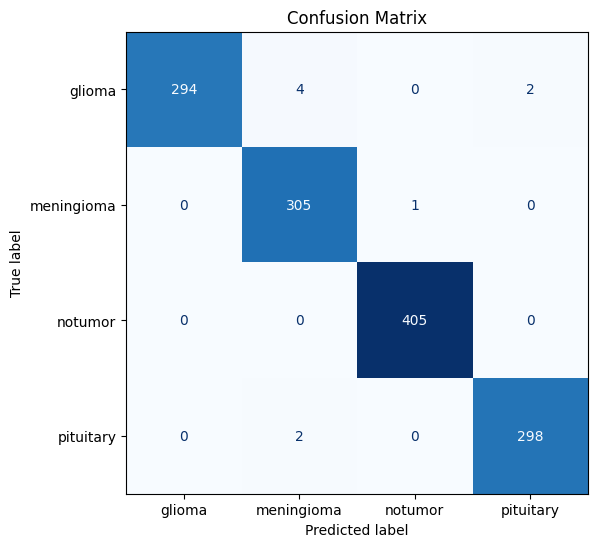

In [19]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

# Usage (after training, use validation or test loader)
plot_confusion_matrix(model, test_loader, train_ds.classes)
